# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p>
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# additional modules used
from collections import deque
from ipywidgets import interact

## Define some useful classes

### Frame

I created this class to make it easy to load and manipulate images. Operations returns Frame objects and this makes it convenient to build and experiment with different pipelines.

In [2]:
class Frame:
    def load(filename):
        return Frame(mpimg.imread(filename))

    def save(self, filename):
        return mpimg.imsave(filename, self.image)

    def weighted(fr1, w1, fr2, w2, c):
        return Frame(cv2.addWeighted(fr1.image, w1, fr2.image, w2, c))
    
    def zeros(shape):
        return Frame(np.ones(shape))
    
    def zeros_like(fr):
        return Frame(np.zeros_like(fr.image))

    def __init__(self, image):
        self.image = image

    def gray(self):
        return Frame(cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY))
    
    def sizexy(self):
        y, x, *_ = self.image.shape
        return (x, y)

    def x_at(self, xfrac):
        xdim, _ = self.sizexy()
        return np.array(xfrac) * xdim

    def y_at(self, yfrac):
        _, ydim = self.sizexy()
        return np.array(yfrac) * ydim

    def rgb(self):
        return Frame(cv2.cvtColor(self.image, cv2.COLOR_GRAY2RGB))

    def blur(self, kernel_size=5):
        return Frame(cv2.GaussianBlur(self.image, (kernel_size, kernel_size), 0))

    def canny(self, low=50, high_multiplier=3):
        return Frame(cv2.Canny(self.image, low, low * high_multiplier))
    
    def sobel(self, dx=1, dy=1, ksize=5, scale=1, delta=0):
        sobel64f = cv2.Sobel(self.image, cv2.CV_64F, dx, dy, ksize=ksize, scale=scale, delta=delta)
        abs_sobel64f = np.absolute(sobel64f)
        return Frame(np.uint8(abs_sobel64f))
    
    def laplacian(self, ksize=3):
        out = cv2.Laplacian(self.image, cv2.CV_64F, ksize=ksize)
        return Frame(out)

    def hist_eq(self):
        if self.is_monochrome():
            return Frame(cv2.equalizeHist(self.image))
        else:
            out = cv2.cvtColor(self.image, cv2.COLOR_RGB2HSV)
            out[:,:,2] = cv2.equalizeHist(out[:,:,2])
            return Frame(cv2.cvtColor(out, cv2.COLOR_HSV2RGB))

    def clahe_eq(self, clip_limit=2, grid_size=8):
        if self.is_monochrome():
            return Frame(cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(grid_size, grid_size)).apply(self.image))
        else:
            out = cv2.cvtColor(self.image, cv2.COLOR_RGB2HSV)
            out[:,:,2] = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(grid_size, grid_size)).apply(out[:,:,2])
            return Frame(cv2.cvtColor(out, cv2.COLOR_HSV2RGB))

    def multiply_scalar(self, value):
        return Frame(cv2.addWeighted(self.image, value, 0, 0, 0))

    def add_scalar(self, value):
        return Frame(cv2.addWeighted(self.image, 1, 0, 0, value))

    def add_weighted(self, self_weight, frame, frame_weight, gamma):
        return Frame(cv2.addWeighted(self.image, self_weight, frame.image, frame_weight, gamma))

    def bitwise_or(self, frame):
        return Frame(cv2.bitwise_or(self.image, frame.image))

    def bitwise_and(self, frame):
        return Frame(cv2.bitwise_and(self.image, frame.image))

    def channels(self, channels):
        out = np.zeros_like(self.image)
        out[..., channels] = self.image[..., channels]
        return Frame(out)

    def channel(self, channel):
        return Frame(self.image[..., channel].copy())

    def hstack(self, frame):
        return Frame(np.hstack([self.image, frame.image]))

    def vstack(self, frame):
        return Frame(np.vstack([self.image, frame.image]))

    def fillpoly(self, vertices, color):
        return Frame(cv2.fillPoly(self.image.copy(), vertices, color))

    def draw_lines(self, lines, color, thickness):
        img = self.image.copy()
        for line in lines:
            x1, y1, x2, y2 = line
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
        return Frame(img)

    def draw_text(self, text, x, y, scale, color, thickness):
        return Frame(cv2.putText(self.image.copy(), text, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, scale, color, thickness, cv2.LINE_AA))

    def hough_lines(self, rho, theta, threshold, min_line_length, max_line_gap):
        out = cv2.HoughLinesP(self.image, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)

        if out is None:
            return np.array([])

        return out[:,0,:]

    def hsv_range_mask(self, hsv_ranges):
        if len(hsv_ranges) == 0:
            raise ValueError('At least one range is required')

        hsv = cv2.cvtColor(self.image, cv2.COLOR_RGB2HSV)

        range_lo, range_hi = hsv_ranges[0]
        mask = cv2.inRange(hsv, range_lo, range_hi)

        for hsv_range in hsv_ranges[1:]:
            range_lo, range_hi = hsv_range
            mask1 = cv2.inRange(hsv, range_lo, range_hi)
            mask = cv2.bitwise_or(mask, mask1)
            
        return Frame(mask)

    def is_monochrome(self):
        return len(self.image.shape) == 2

    def show(self, xdim=None):
        if xdim is not None:
            aspect = self.image.shape[0] / self.image.shape[1]
            plt.figure(figsize=(xdim, aspect * xdim))

        if self.is_monochrome():
            plt.imshow(self.image, cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(self.image)

        plt.axis('off')
        plt.tight_layout()

### FrameGrid

FrameGrid makes it easy to display many images in a grid

In [3]:
class FrameGrid:
    def __init__(self, columns):
        self.columns = columns
        
    def show(self, frames, xdim=6):
        aspect = frames[0].image.shape[0] / frames[0].image.shape[1]
        ydim = aspect * xdim
        rows = len(frames)//self.columns + 1
        fig = plt.figure(figsize=(xdim * self.columns, ydim * rows))
        for i in range(len(frames)):
            if i < len(frames):
                fig.add_subplot(rows, self.columns, i + 1)
                frames[i].show()

### Lines

Lines represent one or more lines and operations on lines/line segments. Grouping lines allows us to make use of optimized numpy functions.

In [4]:
class Lines:
    def from_x_intercepts(lines, xs):
        x1, x2 = xs
        y1, y2 = lines.y_intercept(xs)[0]
        return Lines([[x1, y1, x2, y2]])

    def from_y_intercepts(lines, ys):
        y1, y2 = ys
        x1, x2 = lines.x_intercept(ys)[0]
        return Lines([[x1, y1, x2, y2]])

    def __init__(self, lines):
        if type(lines) == np.ndarray:
            self.lines = lines
        else:
            self.lines = np.array(lines)
        
    def __len__(self):
        return self.lines.__len__()

    def __getitem__(self, i):
        return self.lines.__getitem__(i)

    def __iter__(self):
        return self.lines.__iter__()

    def empty(self):
        return len(self.lines) <= 0

    def centroid(self):
        x1, y1, x2, y2 = self.lines.T
        return np.array([(x1 + x2).T/2, (y1 + y2).T/2]).reshape([-1, 2])
    
    def mean(self):
        if len(self.lines) > 0:
            mean = self.lines.mean(axis=0)
            return Lines(mean.reshape(-1, 4))
        else:
            return Lines([])

    def m(self):
        if len(self.lines) > 0:
            x1, y1, x2, y2 = self.lines.T
            return ((y2 - y1) / (x2 - x1)).reshape((-1, 1))
        else:
            return np.array([])

    def b(self):
        if len(self.lines) > 0:
            x1, y1, x2, y2 = self.lines.T
            return ((x1 * y2 - x2 * y1) / (x1 - x2)).reshape((-1, 1))
        else:
            return np.array([])            

    def y_intercept(self, x):
        return self.m() * x + self.b()

    def x_intercept(self, y):
        return (y - self.b()) / self.m()

    def theta(self):
        return np.arctan(self.m())

    def theta_degrees(self):
        return np.degrees(self.theta())

    def segment_by_theta(self, angle_pairs):
        out = []
        thetas = self.theta_degrees()
        for angle_pair in angle_pairs:
            lines = []
            for i, theta in enumerate(thetas):
                if angle_pair[0] < theta < angle_pair[1]:
                    lines.append(self.lines[i])
            out.append(lines)
            
        return [Lines(lines) for lines in out]

### LaneDetector

LaneDetector implements the lane detection pipeline and makes it easy to test different parameters.

In [5]:
class LaneDetector:
    def __init__(self, params=None):
        self.roi = None
        self.params = {
            'roi': {
                'topy': 0.6,
                'bottomy': 1.0,
                'topw': 0.1,
                'bottomw': 0.9
            },
            'blur': {
                'kernel_size': 9,
            },
            'canny': {
                'low': 30,
                'high_multiplier': 3,
            },
            'hough': {
                'rho': 2,
                'theta': 2 * np.pi/180.0,
                'threshold': 35,
                'min_line_length': 20,
                'max_line_gap': 20
            }
        }
        
        if params is not None:
            self.params = params

    def set_roi(self, frame, topy, bottomy, topw, bottomw):
        self.xdim, self.ydim = frame.sizexy()
        vertices = np.array([[
            (self.xdim * (0.5 - bottomw/2), self.ydim * bottomy),
            (self.xdim * (0.5 - topw/2),    self.ydim * topy),
            (self.xdim * (0.5 + topw/2),    self.ydim * topy),
            (self.xdim * (0.5 + bottomw/2), self.ydim * bottomy)
        ]], dtype=np.int32)

        self.roi = Frame.zeros_like(frame).fillpoly(vertices, [255])

    def detect(self, frame):
        self.gray = frame.gray()
        self.dark = self.gray.multiply_scalar(0.3)
        self.wymask = frame.hsv_range_mask([[(0, 0, 200), (255, 30, 255)], [(10, 90, 180), (40, 255, 255)]])
        self.gray_enhanced = self.dark.bitwise_or(self.wymask)
        self.gray_enhanced_blurred = self.gray_enhanced.blur(**self.params['blur'])
        self.edges = self.gray_enhanced_blurred.canny(**self.params['canny'])
        self.set_roi(self.edges, **self.params['roi'])
        self.masked_edges = self.edges.bitwise_and(self.roi)
        self.lines = Lines(self.masked_edges.hough_lines(**self.params['hough']))
        left, right = self.lines.segment_by_theta([(-38, -27), (27, 38)])

        return left.mean(), right.mean()

### LaneImageProcessor

Takes care of input to output mapping of frames, history, composition, etc.

Passing `debug=True` in the constructor will cause processing to render intermediate images as well in a grid, which is handy to troubleshoot things.

In [6]:
class LaneImageProcessor:
    def __init__(self, lane_detector, history_size=1, debug=False):
        self.lane_detector = lane_detector
        self.history_size = history_size
        self.left_history = deque()
        self.right_history = deque()
        self.debug = debug

    def smooth_and_draw(self, out, history, line, color):
        if not line.empty():
            x1, y1, x2, y2 = line[0]
            while len(history) < self.history_size + 1:
                history.appendleft([x1, y1, x2, y2])

            history.pop()

        if len(history) > 0:
            smooth = np.array(history).mean(axis=0)
            out = self.draw_lane(out, Lines([smooth]))
            
        return out

    def draw_lines(self, out, lines):
        if not lines.empty():
            out = out.draw_lines(lines, [0, 255, 0], 2)

        return out

    def draw_lane(self, out, mean_lane):
        if not mean_lane.empty():
            lane = Lines.from_y_intercepts(mean_lane, out.y_at([0.65, 1.0]))
            out = out.draw_lines(lane, [255, 0, 0], 10)

            centroid = lane.centroid()
            out = out.draw_text("{:+.1f}".format(lane.theta_degrees()[0][0]), centroid[0][0] - 70, centroid[0][1], 1, (255, 255, 255), 2)
            
        return out

    def process(self, frame):
        left, right = self.lane_detector.detect(frame)
        out = Frame.zeros_like(frame)
        out = self.smooth_and_draw(out, self.left_history, left, [255, 0, 0])
        out = self.smooth_and_draw(out, self.right_history, right, [255, 0, 0])
        
        if self.debug:
            im1 = self.lane_detector.gray_enhanced.rgb()
            im2 = self.lane_detector.masked_edges.rgb()
            im3 = self.draw_lines(self.lane_detector.masked_edges.rgb(), self.lane_detector.lines)
            im4 = Frame.weighted(frame, 1.0, out, 0.4, 0)
            row1 = im1.hstack(im2)
            row2 = im3.hstack(im4)
            return row1.vstack(row2)
        else:
            return Frame.weighted(frame, 1.0, out, 0.4, 0)

    def process_as_image(self, image):
        return self.process(Frame(image)).image

## Extract more images from challenge.mp4 for our tests

This writes new files to `in/`. Copy to `test_images/` as needed.

In [7]:
def extract_frames():
    clip = VideoFileClip('challenge.mp4')
    for t in np.arange(0, clip.duration, 0.5):
        outfile = 'in/{}-{}.jpg'.format(challenge_output.split('/')[-1], t)
        print("\r{} / ({}/{})".format(outfile, t, clip.duration), end='')

        clip = clip.resize((960, 540))
        clip.save_frame(outfile, t)

# extract_frames()

## Test the classes

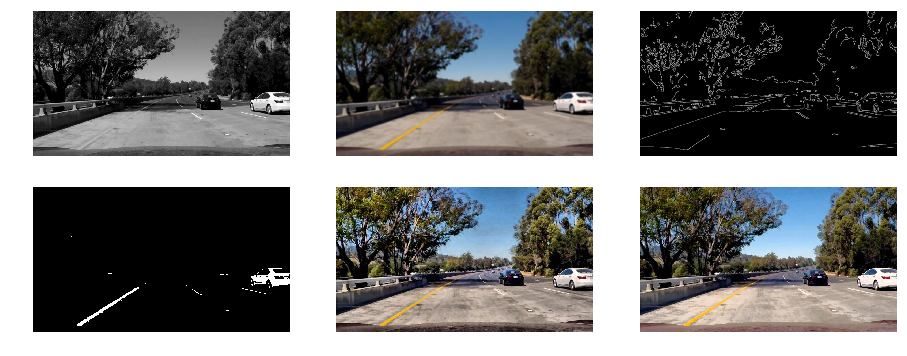

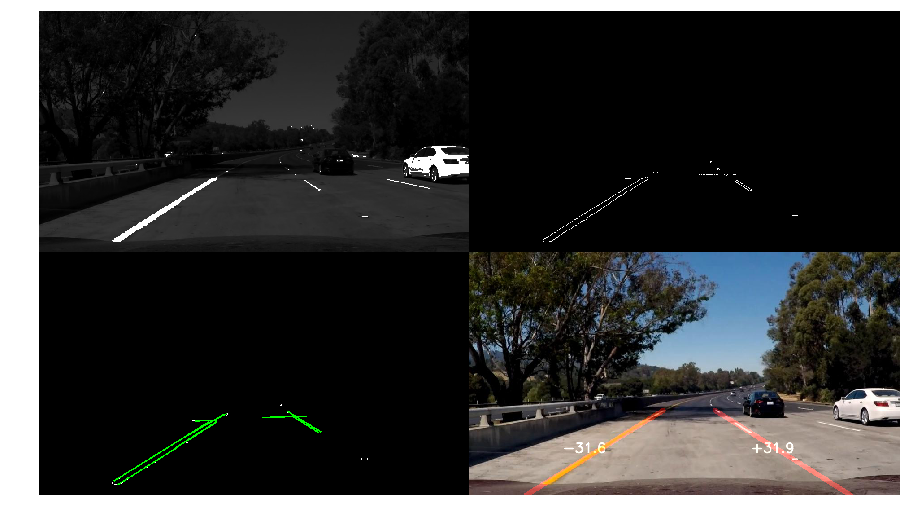

In [8]:
def sample_frame():
    return Frame.load('test_images/extra.mp4-5.5.jpg')

def test_edge_detection():
    return sample_frame().gray().blur(7).canny(50, 3).blur(3)

def test_range_mask():
    return sample_frame().hsv_range_mask([[(0, 0, 200), (255, 30, 255)], [(10, 90, 180), (40, 255, 255)]])

def test_blur():
    return sample_frame().blur(11)

def test_gray():
    return sample_frame().gray()

def test_clahe_eq():
    return sample_frame().clahe_eq()

def test_hist_eq():
    return sample_frame().hist_eq()

FrameGrid(3).show([
    test_gray(),
    test_blur(),
    test_edge_detection(),
    test_range_mask(),
    test_clahe_eq(),
    test_hist_eq()
], 4.3)

detector = LaneDetector()
LaneImageProcessor(detector, history_size=1, debug=True).process(sample_frame()).show(13)

## Make a UI for white/yellow mask tuning

Results from this experiments were used to create white and yellow masks to enhance the lanes

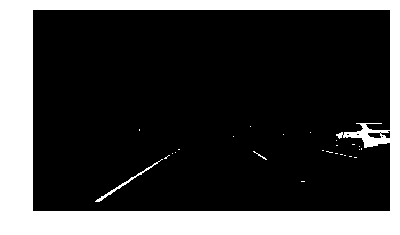

In [9]:
test_frame = Frame.load("test_images/extra.mp4-5.5.jpg")

@interact(h1=(0, 255, 10), h2=(0, 255, 10), s1=(0, 255, 10), s2=(0, 255, 10), v1=(0, 255, 10), v2=(0, 255, 10))
def adjust_rgb(h1=0, h2=255, s1=0, s2=255, v1=220, v2=255):
    test_frame.hsv_range_mask([[(h1, s1, v1), (h2, s2, v2)]]).show(6)

## Make a UI for tuning lane detection params

Optimal parameters as observed from this experiment are adopted as the default parameters in the LaneDetector class. Please note that defaults can be overridden by passing custom parameters to constructor LaneDetector if needed. I used a big monitor so that I could see the sliders and the results at the same time.

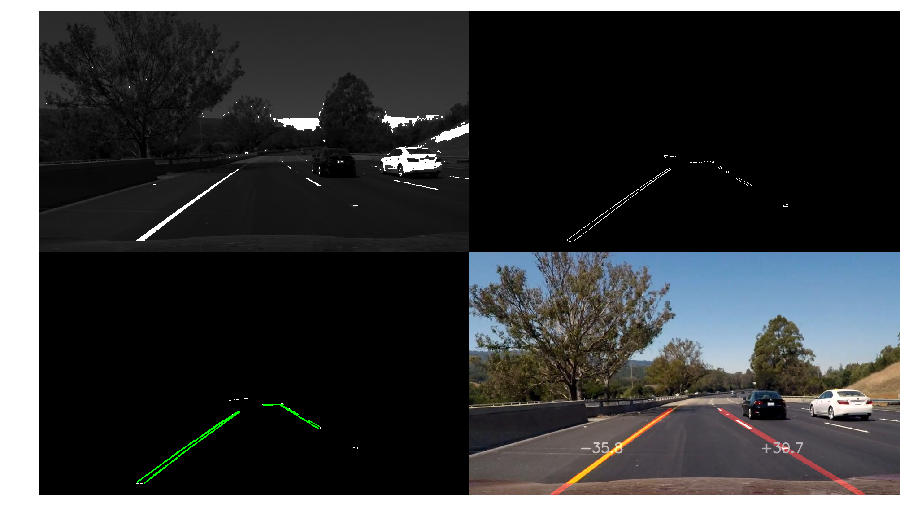

In [10]:
directory = "test_images/"
images = os.listdir(directory)

@interact(img=images, kernel_size=(3,19,2), canny_low=(0,200,10), canny_ratio=[2,3],
          hough_rho=(1,20,1), hough_theta=(1,20,1), hough_thresh=(0,100,1),
          hough_line_min_len=(0,400,5), hough_line_max_gap=(0,400,5))
def detect(img, kernel_size=9, canny_low=30, canny_ratio=3,
           hough_rho=2, hough_theta=2, hough_thresh=35,
           hough_line_min_len=20, hough_line_max_gap=20):
    params = {
        'roi': {
            'topy': 0.6,
            'bottomy': 1.0,
            'topw': 0.1,
            'bottomw': 0.9
        },
        'blur': {
            'kernel_size': kernel_size,
        },
        'canny': {
            'low': canny_low,
            'high_multiplier': canny_ratio,
        },
        'hough': {
            'rho': hough_rho,
            'theta': np.pi/180.0 * hough_theta,
            'threshold': hough_thresh,
            'min_line_length': hough_line_min_len,
            'max_line_gap': hough_line_max_gap
        }
    }
    
    detector = LaneDetector(params)
    processor = LaneImageProcessor(detector, history_size=1, debug=True)
   
    frame = Frame.load("{}/{}".format(directory, img))
    processor.process(frame).show(13)

## Test on sample images

Build your pipeline to work on the images in the directory "test_images"

**You should make sure your pipeline works well on these images before you try the videos.**

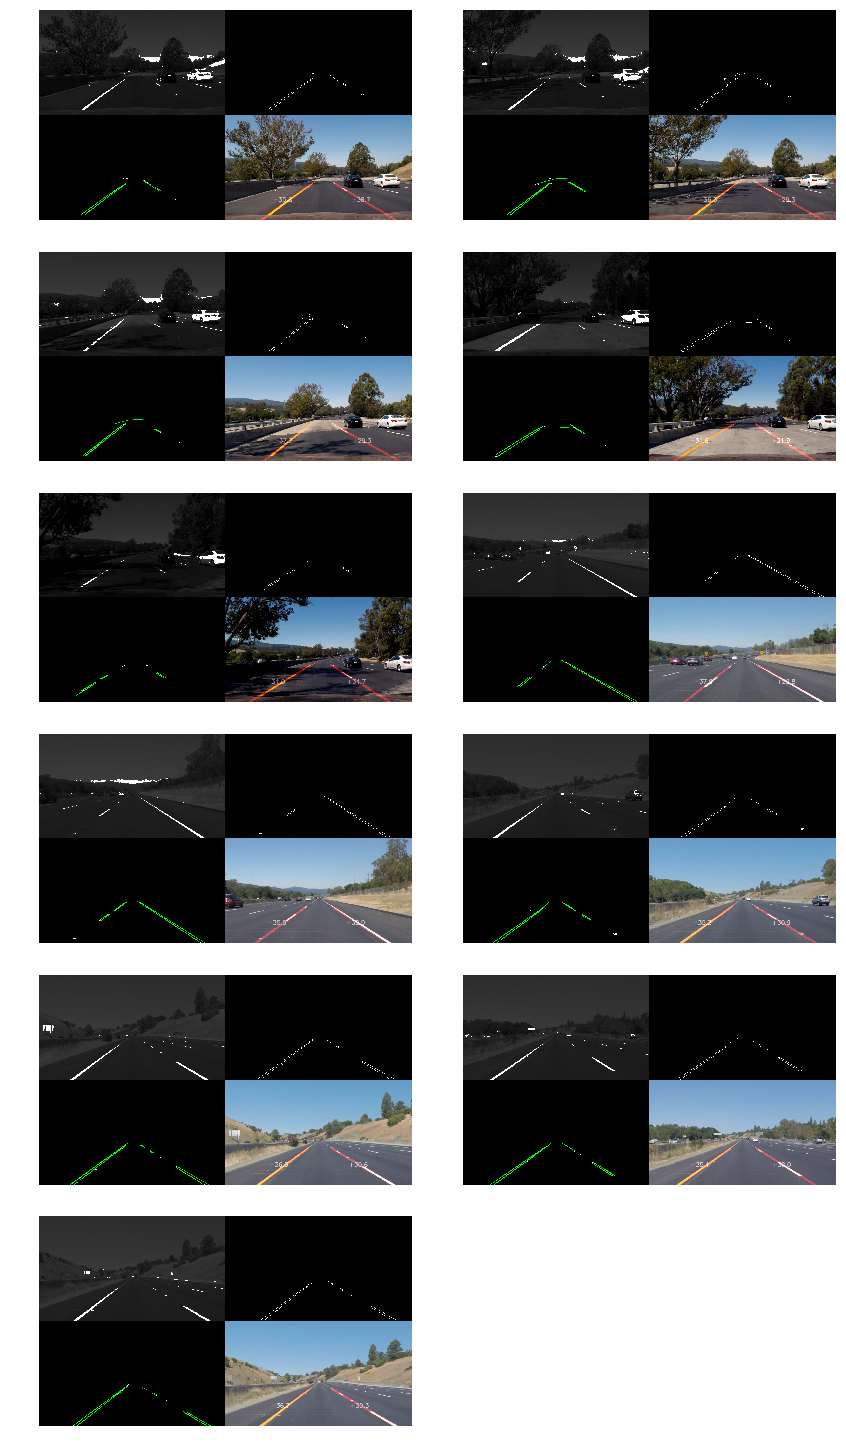

In [11]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the out/ directory.

def files_in(directory):
    return ["{}/{}".format(directory, file) for file in os.listdir(directory) if file[-3:] == 'jpg']

def process_test_images(directory):
    detector = LaneDetector()
    processor = LaneImageProcessor(detector, history_size=1, debug=True)

    filenames = files_in(directory)
    processed = [processor.process(Frame.load(filename)) for filename in filenames]

    FrameGrid(2).show(processed, xdim=6)

    for filename, frame in zip(filenames, processed):
        outfile = "{}/{}-processed.jpg".format("out", filename.split('/')[-1])
        frame.save(outfile)

process_test_images("test_images/")
# process_test_images("in/")

## Test on sample videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [12]:
def process_image(image):
    return find_lanes(image, **args)

def process_video(infile, outfile, debug=False):
    white_output = 'out/white.mp4'
    inclip = VideoFileClip(infile)
    processor = LaneImageProcessor(LaneDetector(), history_size=7, debug=debug)
    outclip = inclip.fl_image(processor.process_as_image)
    outclip.write_videofile(outfile, audio=False)
    return HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(outfile))

Let's try the one with the solid white lane on the right first ...

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
%time process_video('solidWhiteRight.mp4', 'out/white.mp4')

[MoviePy] >>>> Building video out/white.mp4
[MoviePy] Writing video out/white.mp4


100%|█████████▉| 221/222 [00:11<00:00, 11.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out/white.mp4 

CPU times: user 5.87 s, sys: 1.35 s, total: 7.22 s
Wall time: 13.2 s


Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
%time process_video('solidYellowLeft.mp4', 'out/yellow.mp4')

[MoviePy] >>>> Building video out/yellow.mp4
[MoviePy] Writing video out/yellow.mp4


100%|█████████▉| 681/682 [00:24<00:00, 27.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out/yellow.mp4 

CPU times: user 16.7 s, sys: 1.88 s, total: 18.6 s
Wall time: 26.4 s


## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.

The writeup is included in the submission.

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

### Response

In response to the challenge, the pipeline was improved iteratively many times. The pipeline seems to generalize well for the earlier examples as well. The following is a debug render of lane detection on `challenge.mp4`...

In [15]:
%time process_video('challenge.mp4', 'out/extra-debug.mp4', True)

[MoviePy] >>>> Building video out/extra-debug.mp4
[MoviePy] Writing video out/extra-debug.mp4


100%|██████████| 251/251 [00:36<00:00,  7.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out/extra-debug.mp4 

CPU times: user 14.7 s, sys: 5.13 s, total: 19.9 s
Wall time: 41.3 s


And here is the final render of `challenge.mp4`...

In [16]:
%time process_video('challenge.mp4', 'out/extra.mp4')

[MoviePy] >>>> Building video out/extra.mp4
[MoviePy] Writing video out/extra.mp4


100%|██████████| 251/251 [00:19<00:00, 15.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out/extra.mp4 

CPU times: user 11.2 s, sys: 2.03 s, total: 13.2 s
Wall time: 22.7 s
